# Analyzing Scenario Results

In [49]:
import pickle
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from src.configs.shocks import DEBT, LIQUIDITY, VOL, MU, JUMP, NEUTRAL, ADVERSE, SEVERE

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
def get_results(base_dir="../results/"):
    """
    Get all the result objects in the result directory.
    """
    results = []
    files = [os.path.join(base_dir, f) for f in os.listdir(base_dir)]
    for file in files:
        with open(file, "rb") as f:
            result = pickle.load(f)
        results.append(result)
    return results


def get_tags(result):
    shocks = result.metadata["template"].config["shocks"]
    tags = {
        MU: None,
        VOL: None,
        JUMP: None,
        DEBT: None,
        LIQUIDITY: None,
    }
    for shock in shocks:
        if shock["type"] == DEBT:
            tags[DEBT] = shock["tag"]
        elif shock["type"] == LIQUIDITY:
            tags[LIQUIDITY] = shock["tag"]
        elif shock["type"] == VOL:
            tags[VOL] = shock["tag"]
        elif shock["type"] == MU:
            tags[MU] = shock["tag"]
        elif shock["type"] == JUMP:
            tags[JUMP] = shock["tag"]

    for tag in tags:
        if tags[tag] is None:
            tags[tag] = NEUTRAL

    return tags


def compare(results) -> pd.DataFrame:
    stats = []
    for i, result in enumerate(results):
        starting_debt = (
            sum([datum.df["Total Debt"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )
        starting_crvusd_liquidity = (
            sum([datum.df["Total crvUSD Liquidity"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )

        stats_per_run = {
            "Name": result.metadata["template"].name,
            f"Starting Debt (Mns)": starting_debt,
            f"Total crvUSD Liquidity (Mns)": starting_crvusd_liquidity,
            f"Starting Debt:Liquidity Ratio": starting_debt / starting_crvusd_liquidity,
        }

        tags = get_tags(result)
        stats_per_run.update(tags)

        for metric in [
            "Bad Debt Pct",
            "Debt Liquidated Pct",
            "Net LLAMMA Profit Pct",
            "Soft Liquidation Loss Pct",
            # "Borrower Loss Pct",
            # "Aggregator Price",
            "Worst Oracle Error Pct",
            # "Pk Debt",
        ]:
            stats_per_run[f"{metric} Mean"] = result.summary[f"{metric} Max"].mean()
            stats_per_run[f"{metric} Median"] = result.summary[f"{metric} Max"].median()
            stats_per_run[f"{metric} p99"] = result.summary[f"{metric} Max"].quantile(
                0.99
            )

        # NOTE this is important!
        stats_per_run["Pct of LVR Covered by Fees Mean"] = (
            result.summary["Net LLAMMA Profit Pct Max"]
            / result.summary["Soft Liquidation Loss Pct Max"]
        ).mean()
        stats_per_run["Pct of LVR Covered by Fees Median"] = (
            result.summary["Net LLAMMA Profit Pct Max"]
            / result.summary["Soft Liquidation Loss Pct Max"]
        ).median()
        stats_per_run["Pct of LVR Covered by Fees p01"] = (
            result.summary["Net LLAMMA Profit Pct Max"]
            / result.summary["Soft Liquidation Loss Pct Max"]
        ).quantile(0.01)
        stats.append(stats_per_run)

    df = pd.DataFrame(stats).astype(float, errors="ignore").round(2)
    df.sort_values(["Name"])
    return df

In [108]:
results = get_results(base_dir="../results/generic/no_sweep/")
### Temp bugfix
for result in results:
    for row, datum in enumerate(result.data):
        change = (
            datum.df["Net LLAMMA Profit Pct"].iloc[-1]
            - datum.df["Net LLAMMA Profit Pct"].iloc[0]
        )
        result.summary.loc[row, "Net LLAMMA Profit Pct Max"] = change

<Axes: >

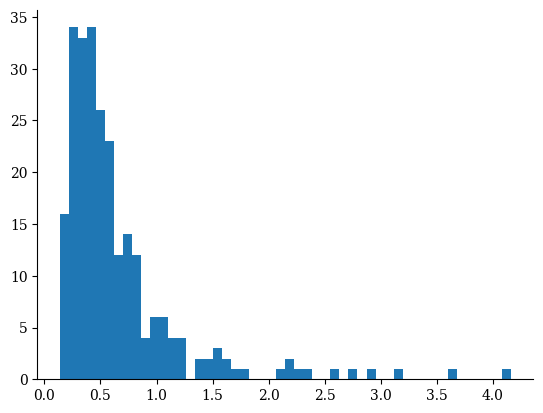

In [195]:
(
    results[0].summary["Net LLAMMA Profit Pct Max"]
    / results[0].summary["Soft Liquidation Loss Pct Max"]
).hist(grid=False, bins=50)

In [196]:
df = compare(results)
df

,Name,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Net LLAMMA Profit Pct Mean,Net LLAMMA Profit Pct Median,Net LLAMMA Profit Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pct of LVR Covered by Fees Mean,Pct of LVR Covered by Fees Median,Pct of LVR Covered by Fees p01
0,Very severe crvUSD Liquidity,110.31,10.43,10.58,neutral,neutral,neutral,neutral,very severe,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.06,0.12,0.12,0.18,0.66,0.48,0.18
1,Severe crvUSD Liquidity,110.24,21.83,5.05,neutral,neutral,neutral,neutral,severe,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.03,0.12,0.12,0.18,0.60,0.49,0.18
2,Severe vol and adverse growth,163.34,70.39,2.32,neutral,severe,neutral,adverse,neutral,0.03,0.0,0.56,1.22,0.56,10.48,0.04,0.02,0.21,0.05,0.03,0.28,0.12,0.12,0.17,0.80,0.83,0.37
3,Adverse crvUSD Liquidity,109.81,31.71,3.46,neutral,neutral,neutral,neutral,adverse,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.07,0.12,0.12,0.19,0.68,0.47,0.21
4,Baseline,110.16,47.43,2.32,neutral,neutral,neutral,neutral,neutral,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.01,0.00,0.13,0.12,0.12,0.17,0.61,0.46,0.18
5,Severe vol and severe crvUSD liquidity,110.16,21.77,5.06,neutral,severe,neutral,neutral,severe,0.02,0.0,0.42,1.42,0.51,10.32,0.04,0.02,0.29,0.05,0.03,0.38,0.16,0.16,0.19,0.80,0.82,0.35
6,Severe vol and severe growth,569.67,245.25,2.32,neutral,severe,neutral,severe,neutral,0.04,0.0,0.61,1.63,1.18,6.16,0.05,0.03,0.18,0.06,0.04,0.21,0.12,0.12,0.18,0.79,0.81,0.38
7,Severe vol and adverse drift,110.03,47.38,2.32,severe,severe,neutral,neutral,neutral,0.05,0.0,0.68,1.70,0.76,11.96,0.07,0.04,0.29,0.08,0.05,0.35,0.12,0.12,0.19,0.86,0.88,0.48
8,Severe vol and very severe crvUSD liquidity,110.09,10.51,10.47,neutral,severe,neutral,neutral,very severe,0.12,0.0,0.61,1.39,0.58,9.91,0.04,0.02,0.26,0.08,0.03,0.38,0.32,0.13,0.20,0.82,0.84,0.30
9,Severe drift,109.55,47.37,2.31,severe,neutral,neutral,neutral,neutral,0.00,0.0,0.00,0.02,0.00,0.00,0.02,0.02,0.12,0.02,0.01,0.13,0.12,0.12,0.18,2.12,2.20,0.43


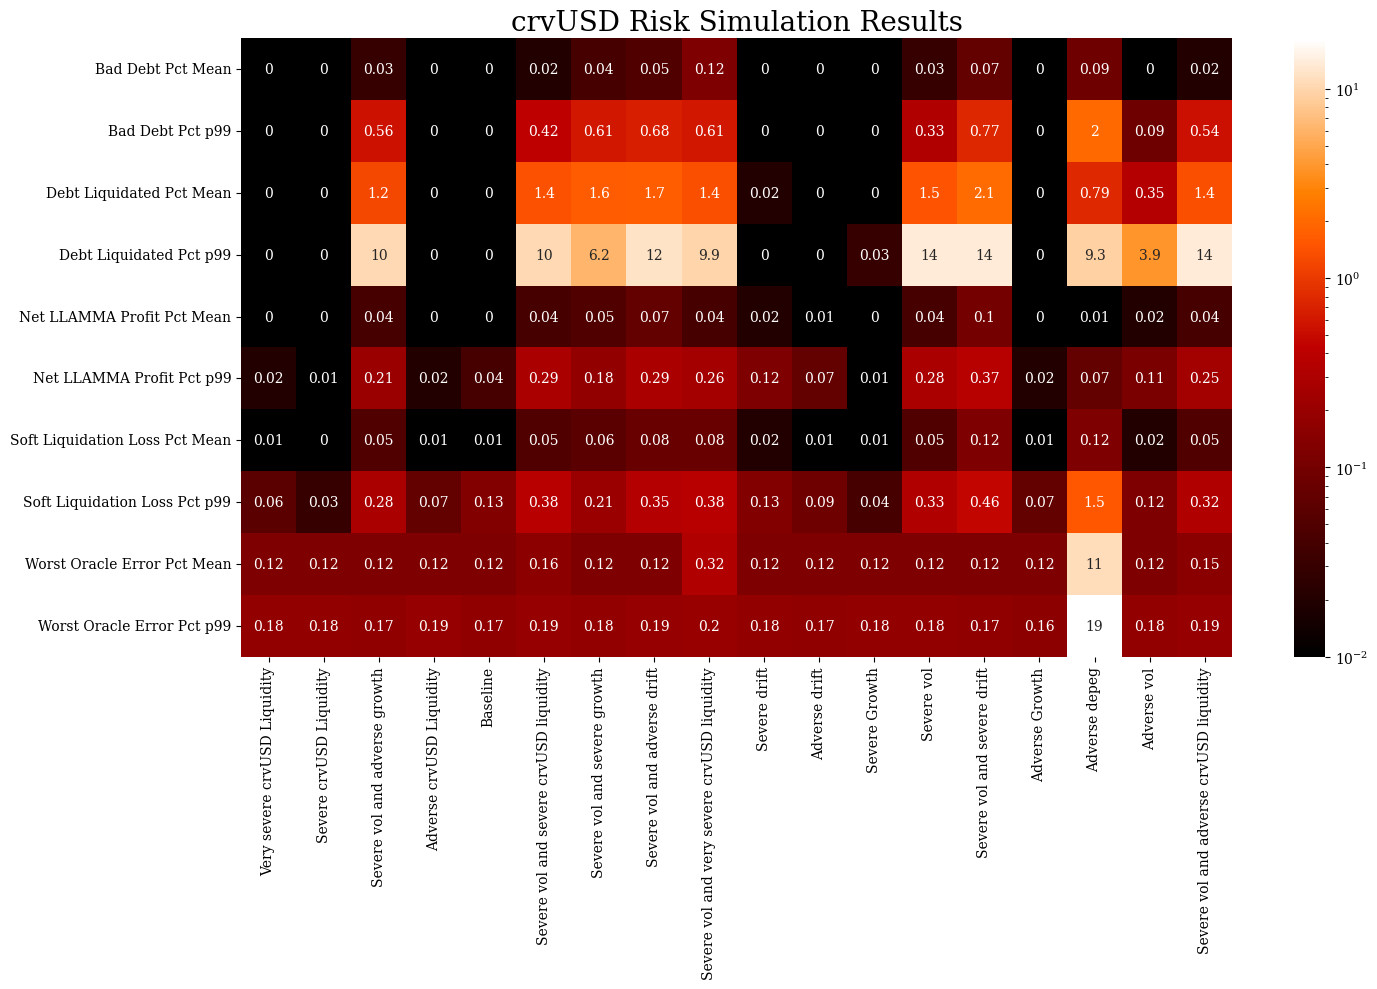

In [160]:
# Create a heatmap
plt.figure(figsize=(15, 10))
mask = df.iloc[:, 9:].T.copy()
# Create a new colormap with the adjusted colors
cmap = plt.cm.gist_heat
cmap.set_extremes(bad="black")
fig = sns.heatmap(
    mask,
    annot=True,
    robust=True,
    xticklabels=df["Name"],
    norm=mcolors.LogNorm(),
    cmap=cmap,
)  # Assuming the first two columns are the indexes
fig.set_title("crvUSD Risk Simulation Results", fontdict={"fontsize": 20})
plt.tight_layout()
plt.savefig("../figs/results/generic.png", dpi=300)
plt.show()

In [115]:
### Zoom in
fixes = {
    VOL: SEVERE,
    MU: NEUTRAL,
    JUMP: NEUTRAL,
    # LIQUIDITY: NEUTRAL,
    DEBT: NEUTRAL,
}
ndf = df.copy()
for col, tag in fixes.items():
    ndf = ndf[ndf[col] == tag]
ndf

,Name,Starting Debt (Mns),Total crvUSD Liquidity (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Mean,Bad Debt Pct p99,Debt Liquidated Pct Mean,Debt Liquidated Pct p99,Soft Liquidation Loss Pct Mean,Soft Liquidation Loss Pct p99,Net LLAMMA Profit Pct Mean,Net LLAMMA Profit Pct p99,Worst Oracle Error Pct Mean,Worst Oracle Error Pct p99
5,Severe vol and severe crvUSD liquidity,110.16,21.77,5.06,neutral,severe,neutral,neutral,severe,0.02,0.42,1.42,10.32,0.05,0.38,0.04,0.29,0.16,0.19
8,Severe vol and very severe crvUSD liquidity,110.09,10.51,10.47,neutral,severe,neutral,neutral,very severe,0.12,0.61,1.39,9.91,0.08,0.38,0.04,0.26,0.32,0.20
12,Severe vol,109.70,47.30,2.32,neutral,severe,neutral,neutral,neutral,0.03,0.33,1.46,13.63,0.05,0.33,0.04,0.28,0.12,0.18
17,Severe vol and adverse crvUSD liquidity,110.60,31.65,3.49,neutral,severe,neutral,neutral,adverse,0.02,0.54,1.38,13.75,0.05,0.32,0.04,0.25,0.15,0.19


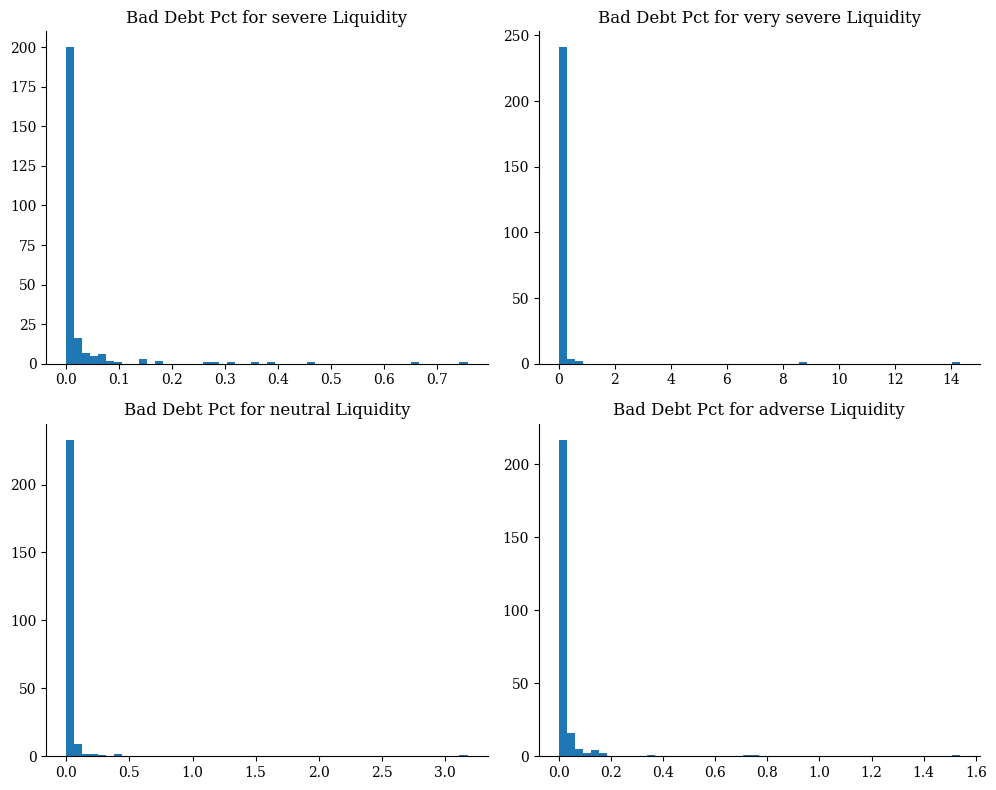

In [137]:
BINS = 50
f, axs = plt.subplots(2, 2, figsize=(10, 8))

ax = axs[0, 0]
results[5].summary["Bad Debt Pct Max"].hist(grid=False, ax=ax, bins=BINS)
ax.set_title(f"Bad Debt Pct for {df.iloc[5]['liquidity']} Liquidity")

ax = axs[0, 1]
results[8].summary["Bad Debt Pct Max"].hist(grid=False, ax=ax, bins=BINS)
ax.set_title(f"Bad Debt Pct for {df.iloc[8]['liquidity']} Liquidity")

ax = axs[1, 0]
results[12].summary["Bad Debt Pct Max"].hist(grid=False, ax=ax, bins=BINS)
ax.set_title(f"Bad Debt Pct for {df.iloc[12]['liquidity']} Liquidity")

ax = axs[1, 1]
results[17].summary["Bad Debt Pct Max"].hist(grid=False, ax=ax, bins=BINS)
ax.set_title(f"Bad Debt Pct for {df.iloc[17]['liquidity']} Liquidity")

plt.tight_layout()
plt.savefig("../figs/results/bad_debt_liquidity.png", dpi=300)
plt.show()

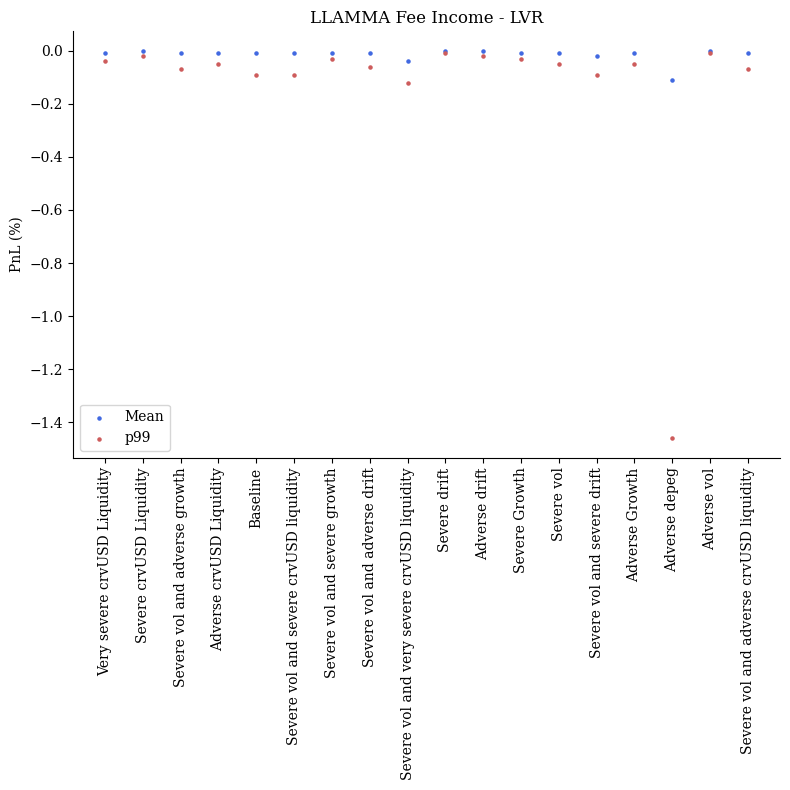

In [157]:
ndf = df.copy()
ndf["Fees - LVR Mean"] = (
    ndf["Net LLAMMA Profit Pct Mean"] - ndf["Soft Liquidation Loss Pct Mean"]
)
ndf["Fees - LVR p99"] = (
    ndf["Net LLAMMA Profit Pct p99"] - ndf["Soft Liquidation Loss Pct p99"]
)

f, ax = plt.subplots(figsize=(8, 8))

ax.scatter(ndf["Name"], ndf["Fees - LVR Mean"], label="Mean", color="royalblue", s=5)
ax.scatter(ndf["Name"], ndf["Fees - LVR p99"], label="p99", color="indianred", s=5)

ax.set_title("LLAMMA Fee Income - LVR")
ax.set_ylabel("PnL (%)")
ax.tick_params(axis="x", rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("../figs/results/fees_lvr.png", dpi=300)
plt.show()

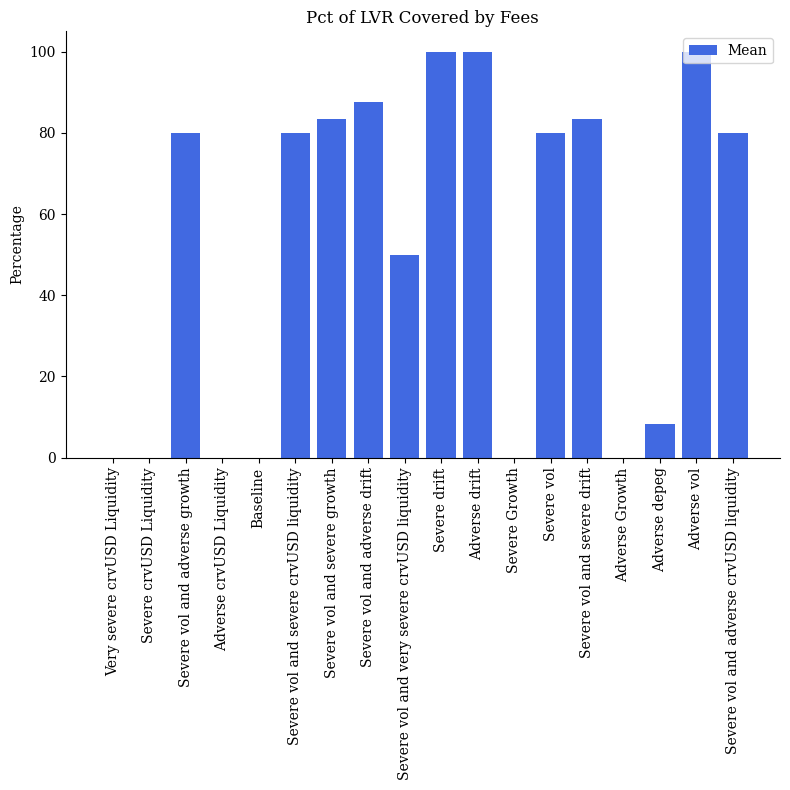

In [168]:
ndf = df.copy()
ndf["PnL Pct Mean"] = (
    ndf["Net LLAMMA Profit Pct Mean"] / ndf["Soft Liquidation Loss Pct Mean"] * 100
)
ndf["PnL Pct p99"] = (
    ndf["Net LLAMMA Profit Pct p99"] / ndf["Soft Liquidation Loss Pct p99"] * 100
)

f, ax = plt.subplots(figsize=(8, 8))

ax.bar(ndf["Name"], ndf["PnL Pct Mean"], label="Mean", color="royalblue")
# ax.bar(ndf["Name"], ndf["PnL Pct p99"], label="Mean", color="indianred")
# ax.scatter(ndf["Name"], ndf["PnL Pct p99"], label="p99", color="indianred", s=5)

ax.set_title("Pct of LVR Covered by Fees")
ax.set_ylabel("Percentage")
ax.tick_params(axis="x", rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("../figs/results/fees_lvr_pct.png", dpi=300)
plt.show()